# EDA about sales, weather, trust in goverment and water quality


In [1]:
#import all the important functions and packages
import pandas as pd
import requests as r
import datetime
import sql_functions as sf
import psycopg2
import matplotlib
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns
import sqlalchemy

### Downloading data tables from SQL Postgres and coverting them into Pandas dataframes

In [2]:
#schema in DBeaver Postgres
schema = 'capstone_anglianwater' 

In [3]:
# Query the newly created table for the sales of bottled water
query1= f'select * from {schema}.uk_bottled_water_production;'
bottled_water = sf.get_dataframe(query1)
# Rename column "value" to "value':'Sales in Million(£)"
bottled_water.rename(columns = {'value':'Sales in Million(£)'}, inplace=True)
bottled_water.head()

,date,Sales in Million(£)
0,1998-01-01,183.0
1,1998-02-01,196.4
2,1998-03-01,243.0
3,1998-04-01,247.7
4,1998-05-01,287.9


In [4]:
# Query the newly created table for weather in UK
query2= f'select * from {schema}.weather_uk;'
weather_mean = sf.get_dataframe(query2)
# rename the column "temp" to full name "Average Temperature"
weather_mean.rename(columns = {'temp':'Average Temperature'}, inplace=True)
weather_mean.head()

,date,Average Temperature
0,1988-01-01,4.1
1,1988-02-01,3.9
2,1988-03-01,5.1
3,1988-04-01,7.1
4,1988-05-01,10.5


In [5]:
# Query the weather date for Summer
query3= f'select * from {schema}.weather_uk where temp > 15;'
weather_mean1 = sf.get_dataframe(query3)
# rename the column "temp" to full name "Average Temperature"
weather_mean1.rename(columns = {'temp':'Average Temperature'}, inplace=True)
print(weather_mean1.info())
print(weather_mean1.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   date                 45 non-null     datetime64[ns]
 1   Average Temperature  45 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 848.0 bytes
None
        date  Average Temperature
0 1989-07-01                 16.4
1 1990-07-01                 15.2
2 1990-08-01                 16.1
3 1991-07-01                 15.9
4 1991-08-01                 15.6
5 1994-07-01                 16.0
6 1995-07-01                 16.6
7 1995-08-01                 17.3
8 1996-08-01                 15.1
9 1997-07-01                 15.3


In [6]:
# Query the weather data for winter
query4= f'select * from {schema}.weather_uk where temp < 7 and temp > 2 ;'
weather_mean2 = sf.get_dataframe(query4)
# rename the column "temp" to full name "Average Temperature"
weather_mean2.rename(columns = {'temp':'Average Temperature'}, inplace=True)
print(weather_mean2.info())
print(weather_mean2.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 166 entries, 0 to 165
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   date                 166 non-null    datetime64[ns]
 1   Average Temperature  166 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.7 KB
None
        date  Average Temperature
0 1988-01-01                  4.1
1 1988-02-01                  3.9
2 1988-03-01                  5.1
3 1988-11-01                  5.0
4 1988-12-01                  6.6
5 1989-01-01                  5.8
6 1989-02-01                  4.9
7 1989-03-01                  6.0
8 1989-04-01                  5.5
9 1989-11-01                  5.7


In [7]:
# merge the data frame summer and winter into one as season
weather_season = pd.concat([weather_mean1,weather_mean2])
weather_season.head(10)

,date,Average Temperature
0,1989-07-01,16.4
1,1990-07-01,15.2
2,1990-08-01,16.1
3,1991-07-01,15.9
4,1991-08-01,15.6
5,1994-07-01,16.0
6,1995-07-01,16.6
7,1995-08-01,17.3
8,1996-08-01,15.1
9,1997-07-01,15.3


In [8]:
# merge the dataframe sales of bottled water and season together
df_bottled_water_season = bottled_water.merge(weather_season, how='inner')
df_bottled_water_season.head(10)

,date,Sales in Million(£),Average Temperature
0,1998-01-01,183.0,4.3
1,1998-02-01,196.4,6.8
2,1998-03-01,243.0,6.7
3,1998-04-01,247.7,6.6
4,1998-11-01,237.4,5.3
5,1998-12-01,248.1,4.9
6,1999-01-01,174.4,4.5
7,1999-02-01,199.5,4.2
8,1999-03-01,268.9,6.2
9,1999-07-01,327.2,15.9


In [9]:
#to compare the difference of mean and max, also read the csv file of max temperature
weather_max= pd.read_csv(r"C:\Users\stell\Documents\neuefische\Tap_vs_Bottle\data\UK_maxtemp.txt", sep='   ' ,skiprows=5, engine='python')
weather_max.columns = weather_max.columns.str.lstrip()
#drop seasons and ann
weather_max.drop(['win', 'spr', 'sum', 'aut','ann'], axis=1 , inplace =True)
#drop unnecessary years
weather_max.drop(range(104),axis=0 ,inplace =True)
#update row index
weather_max.index = range(len(weather_max))

weather_max.rename(columns ={'jan':'1', 'feb':'2', 'mar':'3', 'apr':'4', 'may':'5', 'jun':'6', 'jul':'7', 'aug':'8', 'sep':'9',
       'oct':'10', 'nov':'11', 'dec':'12'}, inplace = True)

#create new table with better suited structure
y = 0
m = 1
weather_max2 = pd.DataFrame({'year':[],'month':[],'temp':[]})

while y < len(weather_max.index):
        while m <= 12: 
                weather_max2.loc[len(weather_max2.index)] = [weather_max.iloc[y,0],m, weather_max.iloc[y,m]]
                m = m+1
        m=1
        y=y+1


#define datatype of columns
weather_max2 = weather_max2.astype({'year':'int', 'month':'int'})
weather_max2['date'] = weather_max2.year.astype(str)+'-' + weather_max2.month.astype(str) +'-' + '1'
weather_max2.date = pd.to_datetime(weather_max2.date)

#drop columns
weather_max2.drop(['year','month'], axis = 1, inplace= True)
weather_max2.rename(columns = {'temp':'Maximum Temperature'}, inplace=True)
weather_max2.head()

,Maximum Temperature,date
0,6.7,1988-01-01
1,6.7,1988-02-01
2,8.2,1988-03-01
3,11.0,1988-04-01
4,15.0,1988-05-01


In [10]:
#merge the datefram of average temperature and max temperature together as total 
weather_total = weather_mean.merge(weather_max2, how='inner')
weather_total.head()

,date,Average Temperature,Maximum Temperature
0,1988-01-01,4.1,6.7
1,1988-02-01,3.9,6.7
2,1988-03-01,5.1,8.2
3,1988-04-01,7.1,11.0
4,1988-05-01,10.5,15.0


In [11]:
# Inner join bottled_water and weather and assign to bottled_water_weather
bottled_water_weather = bottled_water.merge(weather_total,how ='inner',on='date')
# join works on index,so always think to use merge for most of time
# Print info
print(bottled_water_weather.info())
print(bottled_water_weather.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 311 entries, 0 to 310
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   date                 311 non-null    datetime64[ns]
 1   Sales in Million(£)  311 non-null    float64       
 2   Average Temperature  311 non-null    float64       
 3   Maximum Temperature  311 non-null    float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 12.1 KB
None
        date  Sales in Million(£)  Average Temperature  Maximum Temperature
0 1998-01-01                183.0                  4.3                  7.0
1 1998-02-01                196.4                  6.8                  9.8
2 1998-03-01                243.0                  6.7                  9.9
3 1998-04-01                247.7                  6.6                 10.2
4 1998-05-01                287.9                 11.5                 16.0


In [12]:
# upload the newly merged dataset with temperature and sales to DBeaver
#sf.upload(bottled_water_weather,'bottled_water_weather')

The bottled_water_weather table was imported successfully.


In [13]:
# Inner join bottled_water and weather and assign to bottled_water_weather
bottled_water_weather2 = bottled_water.merge(weather_max2,how ='inner',on='date')
# join works on index,so always think to use merge for most of time
# Print info
print(bottled_water_weather2.info())
print(bottled_water_weather2.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 311 entries, 0 to 310
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   date                 311 non-null    datetime64[ns]
 1   Sales in Million(£)  311 non-null    float64       
 2   Maximum Temperature  311 non-null    float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 9.7 KB
None
        date  Sales in Million(£)  Maximum Temperature
0 1998-01-01                183.0                  7.0
1 1998-02-01                196.4                  9.8
2 1998-03-01                243.0                  9.9
3 1998-04-01                247.7                 10.2
4 1998-05-01                287.9                 16.0


In [14]:
# create new columns for the year and month from date 
bottled_water_weather2['year']=bottled_water_weather2['date'].dt.year
bottled_water_weather2['month']=bottled_water_weather2['date'].dt.month
bottled_water_weather2.head()

,date,Sales in Million(£),Maximum Temperature,year,month
0,1998-01-01,183.0,7.0,1998,1
1,1998-02-01,196.4,9.8,1998,2
2,1998-03-01,243.0,9.9,1998,3
3,1998-04-01,247.7,10.2,1998,4
4,1998-05-01,287.9,16.0,1998,5


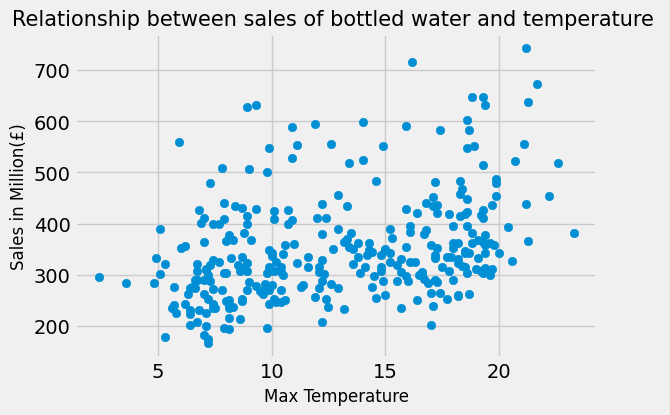

In [15]:
# Use predefined style from the popular FiveThirtyEight website
plt.style.use('fivethirtyeight') 

# Set figure size
plt.figure(figsize=(6, 4))

# Create scatterplpot by specifying x- and y-values
plt.scatter(x =bottled_water_weather2['Maximum Temperature'], y = bottled_water_weather2['Sales in Million(£)'])

# Label your axes
plt.xlabel("Max Temperature", fontsize = 12)
plt.ylabel("Sales in Million(£)", fontsize = 12)

# Set title
plt.title("Relationship between sales of bottled water and temperature ", fontsize = 15)

# Show graphic
plt.show()

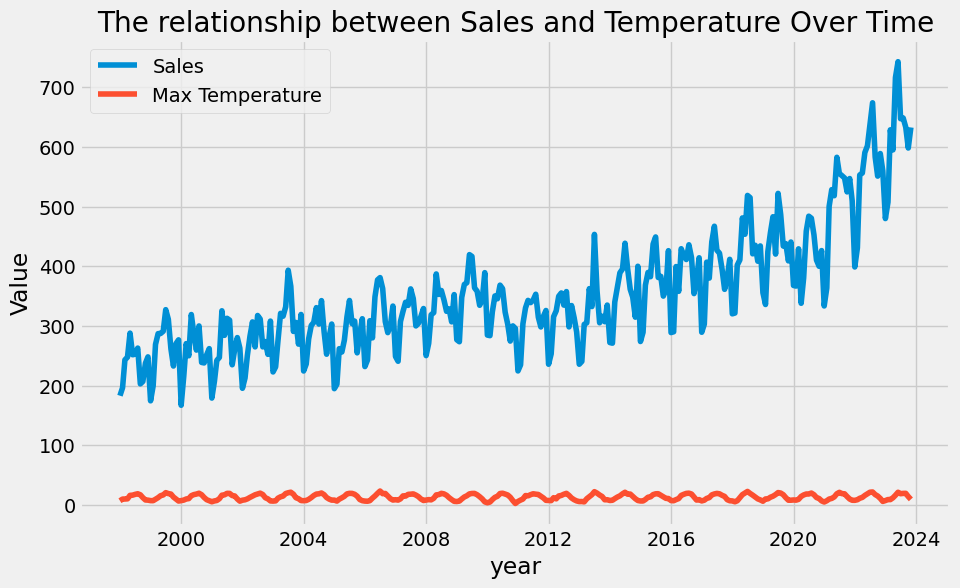

In [16]:
#creat plot to explore the relatioship between sales and temperature
plt.figure(figsize=(10, 6))  
plt.plot(bottled_water_weather2['date'], bottled_water_weather2['Sales in Million(£)'], label='Sales')
plt.plot(bottled_water_weather2['date'], bottled_water_weather2['Maximum Temperature'], label='Max Temperature')
plt.xlabel('year')
plt.ylabel('Value')
plt.title('The relationship between Sales and Temperature Over Time')
plt.legend()
plt.grid(True)
plt.show()

In [17]:
#change the datatype
bottled_water_weather2['year_month'] = bottled_water_weather2['date'].dt.strftime('%Y-%m')
bottled_water_weather2.head()

,date,Sales in Million(£),Maximum Temperature,year,month,year_month
0,1998-01-01,183.0,7.0,1998,1,1998-01
1,1998-02-01,196.4,9.8,1998,2,1998-02
2,1998-03-01,243.0,9.9,1998,3,1998-03
3,1998-04-01,247.7,10.2,1998,4,1998-04
4,1998-05-01,287.9,16.0,1998,5,1998-05


In [18]:
# to get the summer sales in June, July and August
summer_sales2 = bottled_water_weather2[bottled_water_weather2['month'].isin([6, 7, 8])]

# Group by year and calculate the total sales and average temperature for each year
summer_sales_agg2 = summer_sales2.groupby(['year', 'month']).agg({'Sales in Million(£)': 'sum', 'Maximum Temperature': 'max'})

print(summer_sales_agg2)

            Sales in Million(£)  Maximum Temperature
year month                                          
1998 6                    251.6                 16.4
     7                    252.6                 17.7
     8                    262.8                 18.7
1999 6                    291.0                 16.7
     7                    327.2                 20.6
...                         ...                  ...
2022 7                    637.5                 21.3
     8                    673.8                 21.7
2023 6                    742.7                 21.2
     7                    647.1                 18.8
     8                    648.4                 19.3

[78 rows x 2 columns]


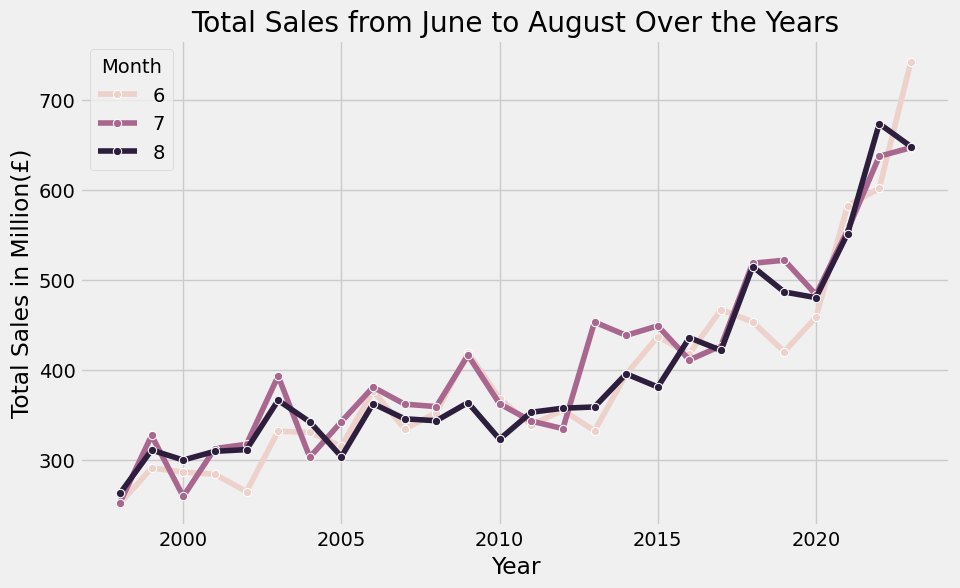

In [19]:
# creat the plot to see the sales trend in summer 
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
sns.lineplot(data=summer_sales_agg2, x='year', y='Sales in Million(£)', hue='month', marker='o')
plt.xlabel('Year')
plt.ylabel('Total Sales in Million(£)')
plt.title('Total Sales from June to August Over the Years')
plt.legend(title='Month', loc='upper left')
plt.grid(True)
plt.show()

In [20]:
# Filter the DataFrame for summer months (June, July, August)
summer_sales2 = bottled_water_weather2[bottled_water_weather2['month'].isin([6, 7, 8])]

# Filter the DataFrame for winter months (December, January, February)
winter_sales = bottled_water_weather2[bottled_water_weather2['month'].isin([12, 1, 2])]

# Concatenate the summer and winter sales DataFrames
seasonal_sales = pd.concat([summer_sales2, winter_sales])

# Group by year and calculate the total sales and maximum temperature for each year
seasonal_sales_agg = seasonal_sales.groupby(['year', 'month']).agg({'Sales in Million(£)': 'sum', 'Maximum Temperature': 'max'})

print(seasonal_sales_agg)

            Sales in Million(£)  Maximum Temperature
year month                                          
1998 1                    183.0                  7.0
     2                    196.4                  9.8
     6                    251.6                 16.4
     7                    252.6                 17.7
     8                    262.8                 18.7
...                         ...                  ...
2023 1                    479.8                  7.3
     2                    507.4                  9.0
     6                    742.7                 21.2
     7                    647.1                 18.8
     8                    648.4                 19.3

[155 rows x 2 columns]


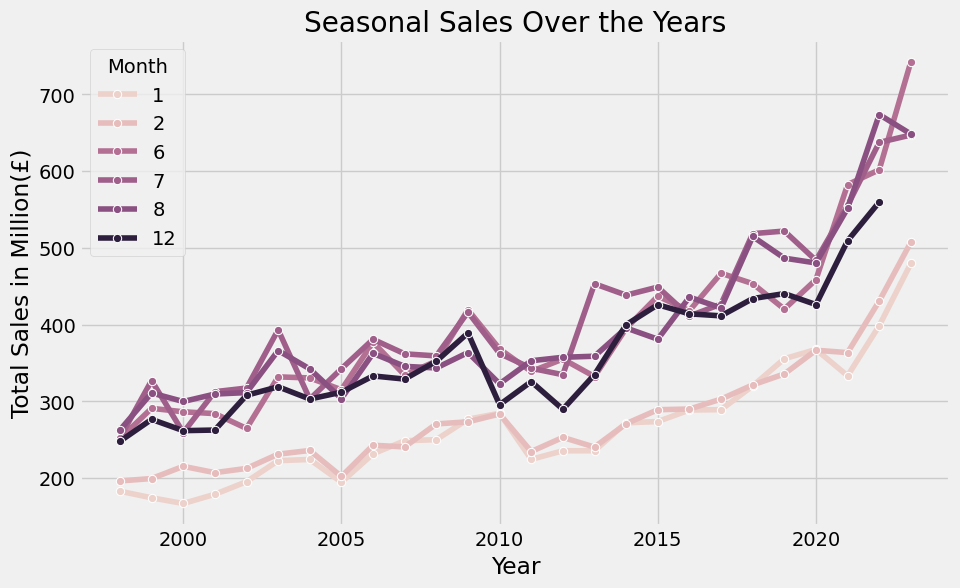

In [21]:
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed

# Create a line plot
sns.lineplot(data=seasonal_sales_agg, x='year', y='Sales in Million(£)', hue='month', marker='o')

# Set labels and title
plt.xlabel('Year')
plt.ylabel('Total Sales in Million(£)')
plt.title('Seasonal Sales Over the Years')

# Add legend and grid
plt.legend(title='Month', loc='upper left')
plt.grid(True)

# Show the plot
plt.show()

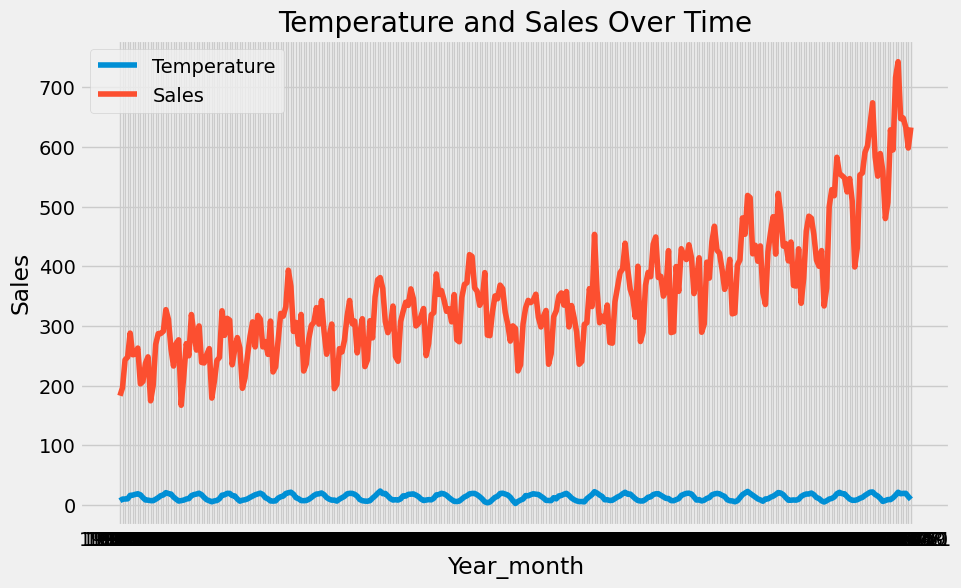

In [22]:
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed

# Plot temperature
sns.lineplot(x='year_month', y='Maximum Temperature', data=bottled_water_weather2, label='Temperature')

# Plot sales
sns.lineplot(x='year_month', y='Sales in Million(£)', data=bottled_water_weather2, label='Sales')

plt.xlabel('Year_month')
plt.ylabel('Sales')
plt.title('Temperature and Sales Over Time')
plt.legend()
plt.grid(True)
plt.show()

<Axes: xlabel='year_month', ylabel='Maximum Temperature'>

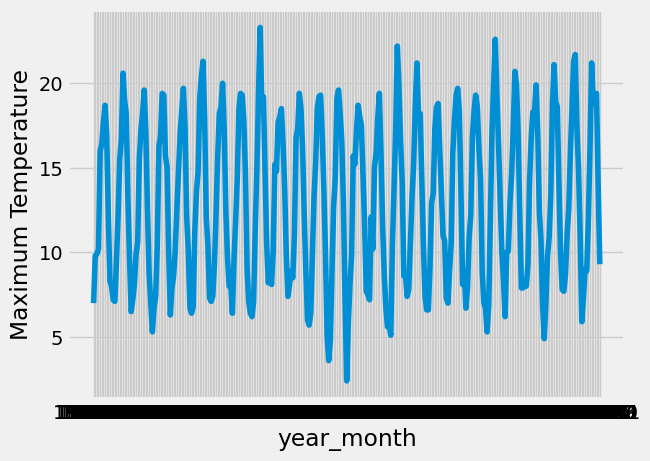

In [23]:
#create lineplot to explore the temperature changes in years
sns.lineplot(x='year_month',y= 'Maximum Temperature',data=bottled_water_weather2)

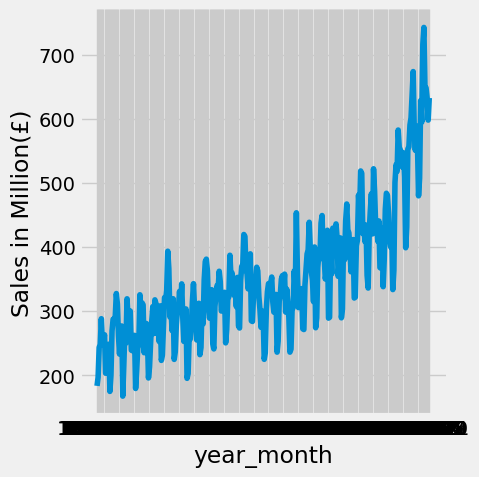

In [24]:
#create the plot to explore the sales trend in years
sns.relplot(x='year_month', y='Sales in Million(£)', data=bottled_water_weather2, kind='line')

In [25]:
# Query the trust in goverment data
query5= f'select * from {schema}.trust_in_gov;'
trust_in_gov = sf.get_dataframe(query5)
trust_in_gov.head()

,year,canada,france,germany,italy,japan,united kingdom,united states
0,2006,44.3,32.5,32.2,23.9,35.0,49.5,55.8
1,2007,63.8,36.1,35.0,30.3,24.0,36.4,39.3
2,2008,59.0,45.3,43.2,36.3,22.1,32.4,37.9
3,2009,60.8,47.4,53.3,40.0,25.2,38.4,50.3
4,2010,55.1,40.1,39.5,33.4,27.0,50.4,41.8


In [26]:
# change the datatype of date from the dataframe of trust in goverment 
trust_in_gov['date'] = pd.to_datetime(trust_in_gov['year'], format='%Y')
trust_in_gov.drop(['year'], axis = 1, inplace= True)
trust_in_gov.head()

,canada,france,germany,italy,japan,united kingdom,united states,date
0,44.3,32.5,32.2,23.9,35.0,49.5,55.8,2006-01-01
1,63.8,36.1,35.0,30.3,24.0,36.4,39.3,2007-01-01
2,59.0,45.3,43.2,36.3,22.1,32.4,37.9,2008-01-01
3,60.8,47.4,53.3,40.0,25.2,38.4,50.3,2009-01-01
4,55.1,40.1,39.5,33.4,27.0,50.4,41.8,2010-01-01


In [27]:
# merge the dataframe of trust with sales of bottled water
bottled_water_trust = bottled_water.merge(trust_in_gov,how='inner')
bottled_water_trust.head(17)

,date,Sales in Million(£),canada,france,germany,italy,japan,united kingdom,united states
0,2006-01-01,231.8,44.3,32.5,32.2,23.9,35.0,49.5,55.8
1,2007-01-01,248.7,63.8,36.1,35.0,30.3,24.0,36.4,39.3
2,2008-01-01,250.2,59.0,45.3,43.2,36.3,22.1,32.4,37.9
3,2009-01-01,276.8,60.8,47.4,53.3,40.0,25.2,38.4,50.3
4,2010-01-01,284.6,55.1,40.1,39.5,33.4,27.0,50.4,41.8
5,2011-01-01,224.5,55.3,37.5,42.5,26.0,23.1,46.8,38.3
6,2012-01-01,235.7,52.3,44.1,51.7,28.1,16.9,42.1,34.9
7,2013-01-01,235.7,50.6,39.5,55.8,14.6,35.8,37.9,28.9
8,2014-01-01,272.1,51.7,26.4,60.1,30.9,38.0,42.3,34.9
9,2015-01-01,273.8,64.4,32.8,62.8,26.1,35.3,45.7,34.7


In [28]:
#drop the year 2022,coz there is no date for UK
bottled_water_trust = bottled_water_trust[:-1]
bottled_water_trust.head(16)

,date,Sales in Million(£),canada,france,germany,italy,japan,united kingdom,united states
0,2006-01-01,231.8,44.3,32.5,32.2,23.9,35.0,49.5,55.8
1,2007-01-01,248.7,63.8,36.1,35.0,30.3,24.0,36.4,39.3
2,2008-01-01,250.2,59.0,45.3,43.2,36.3,22.1,32.4,37.9
3,2009-01-01,276.8,60.8,47.4,53.3,40.0,25.2,38.4,50.3
4,2010-01-01,284.6,55.1,40.1,39.5,33.4,27.0,50.4,41.8
5,2011-01-01,224.5,55.3,37.5,42.5,26.0,23.1,46.8,38.3
6,2012-01-01,235.7,52.3,44.1,51.7,28.1,16.9,42.1,34.9
7,2013-01-01,235.7,50.6,39.5,55.8,14.6,35.8,37.9,28.9
8,2014-01-01,272.1,51.7,26.4,60.1,30.9,38.0,42.3,34.9
9,2015-01-01,273.8,64.4,32.8,62.8,26.1,35.3,45.7,34.7


In [40]:
# upload the new merged datafram to DBeaver
sf.upload(bottled_water_trust,'bottled_water_sales_trust')

In [31]:
from scipy.stats import pearsonr

#use statistical package to calculate Pearson correlation coefficient between sales and temperature 
sales = bottled_water_weather['Sales in Million(£)']
avg_temp = bottled_water_weather['Average Temperature']

# Calculate Pearson correlation coefficient and p-value
correlation_coefficient, p_value = pearsonr(sales, avg_temp)

print("Pearson correlation coefficient:", correlation_coefficient)
print("p-value:", p_value)


Pearson correlation coefficient: 0.36072403739359743
p-value: 5.45605883820855e-11


In [32]:
#check Pearson correlation coefficient betweeen sales and trust in goverment
sales= bottled_water_trust['Sales in Million(£)']
trust = bottled_water_trust['united kingdom']

# Calculate Pearson correlation coefficient and p-value
correlation_coefficient, p_value = pearsonr(sales,trust)

print("Pearson correlation coefficient:", correlation_coefficient)
print("p-value:", p_value)

Pearson correlation coefficient: -0.3697022945811055
p-value: 0.15872371802726598


In [34]:
# Query the newly created table of water quality 
query9= f'select sample_id, sample_date, determinand,units, result from {schema}.water_quality where result > 0;'
aw_water_quality = sf.get_dataframe(query9)
aw_water_quality.head(10)

,sample_id,sample_date,determinand,units,result
0,0d8ac3ad-a3f4-49a4-8810-261d0a9d9046,2022-01-03,Residual Disinfectant - Free,mg/l,0.520
1,0d8ac3ad-a3f4-49a4-8810-261d0a9d9046,2022-01-03,Residual Disinfectant - Total,mg/l,0.840
2,f55a938a-33ae-4f79-849f-e92f4f1b27a4,2022-01-03,Residual Disinfectant - Free,mg/l,0.570
3,f55a938a-33ae-4f79-849f-e92f4f1b27a4,2022-01-03,Residual Disinfectant - Total,mg/l,0.680
4,320bf427-4b54-4c57-944c-a568c712c955,2022-01-04,Colour,Hazen,0.680
5,320bf427-4b54-4c57-944c-a568c712c955,2022-01-04,Turbidity,NTU,0.100
6,320bf427-4b54-4c57-944c-a568c712c955,2022-01-04,Hydrogen ion (pH) - Indicator (Hydrogen ion) (pH),pH value,7.430
7,320bf427-4b54-4c57-944c-a568c712c955,2022-01-04,Nitrate (Total),mg/l NO3,13.900
8,320bf427-4b54-4c57-944c-a568c712c955,2022-01-04,Nitrite - Consumer's Taps,mg/l NO2,0.030
9,320bf427-4b54-4c57-944c-a568c712c955,2022-01-04,Nitrite/Nitrate formula,mg/l,0.278


In [35]:
# get the distinct value of determinand 
aw_water_quality['determinand'].unique()

array(['Residual Disinfectant - Free', 'Residual Disinfectant - Total',
       'Colour', 'Turbidity',
       'Hydrogen ion (pH) - Indicator (Hydrogen ion) (pH)',
       'Nitrate (Total)', "Nitrite - Consumer's Taps",
       'Nitrite/Nitrate formula', 'Ammonium (Total)', 'Aluminium (Total)',
       'Iron (Total)', 'Manganese (Total)',
       'Conductivity (Electrical Conductivity)', 'Sodium (Total)',
       'Copper (Total)', 'Fluoride (Total)', 'Arsenic (Total)',
       'Cadmium (Total)', 'Chromium (Total)', 'Nickel (Total)',
       'Lead (10 - will apply 25.12.2013)', 'Antimony',
       'Selenium (Total)', 'Benzo[a]Pyrene (Total)',
       'Colony Counts After 3 Days At 22øc (Colony Counts)',
       'Gross Alpha', 'Gross Beta', 'Tritium',
       'Coliform Bacteria (Indicator)', 'Sulphate',
       'Total Organic Carbon', 'Cyanide (Total)', 'Mercury (Total)',
       'Pesticides (Total by Calculation)', 'Chloride', 'Boron',
       'Tetrachloromethane (Total)', '1 2-Dichloroethane (Total)',

In [36]:
# according to WHO guildline to choose the determinand that have effects on human health
desired_determinands = ['Arsenic (Total)',
                        'Boron',
                        'Copper (Total)',
                        'Chloride',
                        'Chromium (Total)',
                        'Fluoride (Total)',
                        #'Manganese (Total)',
                        'Selenium (Total)',
                        #'Sodium (Total)',
                        'Lead (10 - will apply 25.12.2013)']

#chemical parameters and their related harmful effects:
#Arsenic_cancer, Boron_stomach/intenstine/liver/kidney/brain, Fluoride_dental fluorosis/bone damage
#Lead_childrens brain and nerve, Selenium_breathing issues, kidney failure, and heart problems
# Use boolean indexing to filter the DataFrame
water_elements = aw_water_quality[aw_water_quality['determinand'].isin(desired_determinands)]

print(water_elements.info())


<class 'pandas.core.frame.DataFrame'>
Int64Index: 7998 entries, 69 to 86185
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   sample_id    7998 non-null   object        
 1   sample_date  7998 non-null   datetime64[ns]
 2   determinand  7998 non-null   object        
 3   units        7998 non-null   object        
 4   result       7998 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 374.9+ KB
None


In [37]:
#use info to confirm all the datatype 
water_elements.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7998 entries, 69 to 86185
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   sample_id    7998 non-null   object        
 1   sample_date  7998 non-null   datetime64[ns]
 2   determinand  7998 non-null   object        
 3   units        7998 non-null   object        
 4   result       7998 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 374.9+ KB


In [39]:
#upload the water elements dataframe to DBeaver
#sf.upload(water_elements,'water_elements')

In [40]:
#sf.upload(water_elements_pivot,'water_elements_new')

In [41]:
# initialize data of lists for data standard
data = {'determinand': ['Arsenic (Total)','Boron','Copper (Total)','Chloride','Chromium (Total)','Fluoride (Total)','Selenium (Total)','Lead (10 - will apply 25.12.2013)'],
                   'standard' : [10, 1.0, 2.0, 250, 50, 1.5, 10, 10],
                   'units': ['μg/l As', 'mg/l B', 'mg/l Cu', 'mg/l C','μg/l Cr','mg/l F','μg/l Se','μg/l Pb']}


# Create DataFrame as water standard 
water_standard = pd.DataFrame(data)
water_standard

,determinand,standard,units
0,Arsenic (Total),10.0,μg/l As
1,Boron,1.0,mg/l B
2,Copper (Total),2.0,mg/l Cu
3,Chloride,250.0,mg/l C
4,Chromium (Total),50.0,μg/l Cr
5,Fluoride (Total),1.5,mg/l F
6,Selenium (Total),10.0,μg/l Se
7,Lead (10 - will apply 25.12.2013),10.0,μg/l Pb


In [42]:
#upload the dataframe to DBeaver 
#sf.upload(water_standard,'water_standard')